# Description

Runs k-means on the z_score_std version of the data.

# Environment variables

In [1]:
from IPython.display import display

import conf

N_JOBS = conf.GENERAL["N_JOBS"]
display(N_JOBS)

3

In [2]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=3
env: OPEN_BLAS_NUM_THREADS=3
env: NUMEXPR_NUM_THREADS=3
env: OMP_NUM_THREADS=3


# Modules loading

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import generate_result_set_name

# Settings

In [5]:
np.random.seed(0)

In [6]:
INITIAL_RANDOM_STATE = 0

## Input data

In [7]:
INPUT_SUBSET = "z_score_std"

In [8]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [9]:
input_filepath = Path(
    conf.RESULTS["CLUSTERING_NULL_DIR"],
    "data_transformations",
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/opt/data/results/clustering/null_sims/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

## Clustering

In [10]:
from sklearn.cluster import KMeans

In [11]:
CLUSTERING_ATTRIBUTES_TO_SAVE = ["n_clusters"]

In [12]:
CLUSTERING_OPTIONS = {}

CLUSTERING_OPTIONS["K_MIN"] = 2
CLUSTERING_OPTIONS["K_MAX"] = 60  # sqrt(3749)
CLUSTERING_OPTIONS["N_REPS_PER_K"] = 5
CLUSTERING_OPTIONS["KMEANS_N_INIT"] = 10

display(CLUSTERING_OPTIONS)

{'K_MIN': 2, 'K_MAX': 60, 'N_REPS_PER_K': 5, 'KMEANS_N_INIT': 10}

In [13]:
CLUSTERERS = {}

idx = 0
random_state = INITIAL_RANDOM_STATE

for k in range(CLUSTERING_OPTIONS["K_MIN"], CLUSTERING_OPTIONS["K_MAX"] + 1):
    for i in range(CLUSTERING_OPTIONS["N_REPS_PER_K"]):
        clus = KMeans(
            n_clusters=k,
            n_init=CLUSTERING_OPTIONS["KMEANS_N_INIT"],
            random_state=random_state,
        )

        method_name = type(clus).__name__
        CLUSTERERS[f"{method_name} #{idx}"] = clus

        random_state = random_state + 1
        idx = idx + 1

In [14]:
display(len(CLUSTERERS))

295

In [15]:
_iter = iter(CLUSTERERS.items())
display(next(_iter))
display(next(_iter))

('KMeans #0', KMeans(n_clusters=2, random_state=0))

('KMeans #1', KMeans(n_clusters=2, random_state=1))

In [16]:
clustering_method_name = method_name
display(clustering_method_name)

'KMeans'

## Output directory

In [17]:
# output dir for this notebook
RESULTS_DIR = Path(
    conf.RESULTS["CLUSTERING_NULL_DIR"],
    "runs",
    f"{INPUT_SUBSET}-{INPUT_STEM}",
).resolve()
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

display(RESULTS_DIR)

PosixPath('/opt/data/results/clustering/null_sims/runs/z_score_std-projection-smultixcan-efo_partial-mashr-zscores')

# Load input file

In [18]:
data = pd.read_pickle(input_filepath)

In [19]:
data.shape

(3752, 987)

In [20]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-2.408007,-1.745911,1.383013,0.158718,-0.240933,-0.304911,1.823117,-0.716278,-1.769346,-0.043794,...,0.399227,0.849885,-0.593292,0.636568,0.409726,-0.871713,1.638770,0.285165,0.585307,0.592347
100002_raw-Energy,-0.508508,0.514427,-0.792865,-0.091775,-0.013409,0.194047,1.353713,0.117286,-0.323516,-1.641116,...,-0.038535,-1.139394,-0.951591,1.197872,0.893819,-0.820655,0.928634,-0.716778,-0.085735,-1.208965
100003_raw-Protein,-0.284597,-0.325076,-1.412980,1.255510,0.343603,-2.471878,-0.149640,-0.715178,-0.548948,1.210352,...,1.006094,0.595064,1.774559,-0.335165,0.394177,-0.188345,-1.864716,-0.124875,1.253625,0.804944
100004_raw-Fat,-0.427503,-0.096524,-0.348654,-1.250087,-0.253145,-0.236606,-0.600627,0.277239,-0.844748,-0.998437,...,0.249993,-1.520660,0.037241,0.514992,0.512538,-1.083619,0.310643,-1.719033,-0.970770,-2.628077
100005_raw-Carbohydrate,-1.502621,-1.083034,0.531159,0.332981,-1.240640,-0.852565,-0.003171,0.561912,-0.772413,-0.372739,...,-0.577730,-1.163380,0.000251,-0.345607,-1.610004,0.194078,0.605594,1.182825,-1.567705,-0.011902


In [21]:
assert not data.isna().any().any()

# Clustering

## Generate ensemble

In [22]:
from clustering.ensembles.utils import generate_ensemble

In [23]:
ensemble = generate_ensemble(
    data,
    CLUSTERERS,
    attributes=CLUSTERING_ATTRIBUTES_TO_SAVE,
)

100%|██████████| 295/295 [16:46<00:00,  3.41s/it]


In [24]:
# the number should be close to 295 (the number of partitions generated by k-means/spectral clustering)
ensemble.shape

(295, 3)

In [25]:
ensemble.head()

,clusterer_params,partition,n_clusters
clusterer_id,,,
KMeans #0,"{'algorithm': 'auto', 'copy_x': True, 'init': ...","[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",2
KMeans #1,"{'algorithm': 'auto', 'copy_x': True, 'init': ...","[0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",2
KMeans #2,"{'algorithm': 'auto', 'copy_x': True, 'init': ...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...",2
KMeans #3,"{'algorithm': 'auto', 'copy_x': True, 'init': ...","[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...",2
KMeans #4,"{'algorithm': 'auto', 'copy_x': True, 'init': ...","[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2


In [26]:
ensemble["n_clusters"].value_counts().head()

60    5
16    5
28    5
27    5
26    5
Name: n_clusters, dtype: int64

In [27]:
ensemble_stats = ensemble["n_clusters"].describe()
display(ensemble_stats)

count    295.000000
mean      31.000000
std       17.058323
min        2.000000
25%       16.000000
50%       31.000000
75%       46.000000
max       60.000000
Name: n_clusters, dtype: float64

## Testing

In [28]:
assert ensemble_stats["min"] > 1

In [29]:
assert not ensemble["n_clusters"].isna().any()

In [30]:
assert ensemble.shape[0] == len(CLUSTERERS)

In [31]:
# all partitions have the right size
assert np.all(
    [part["partition"].shape[0] == data.shape[0] for idx, part in ensemble.iterrows()]
)

In [32]:
# no partition has negative clusters (noisy points)
assert not np.any([(part["partition"] < 0).any() for idx, part in ensemble.iterrows()])

## Add clustering quality measures

In [33]:
from sklearn.metrics import calinski_harabasz_score

In [34]:
ensemble = ensemble.assign(
    ch_score=ensemble["partition"].apply(lambda x: calinski_harabasz_score(data, x))
)

In [35]:
ensemble.shape

(295, 4)

In [36]:
ensemble.head()

,clusterer_params,partition,n_clusters,ch_score
clusterer_id,,,,
KMeans #0,"{'algorithm': 'auto', 'copy_x': True, 'init': ...","[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",2,5.522721
KMeans #1,"{'algorithm': 'auto', 'copy_x': True, 'init': ...","[0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",2,5.543418
KMeans #2,"{'algorithm': 'auto', 'copy_x': True, 'init': ...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...",2,5.648999
KMeans #3,"{'algorithm': 'auto', 'copy_x': True, 'init': ...","[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...",2,5.503176
KMeans #4,"{'algorithm': 'auto', 'copy_x': True, 'init': ...","[0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2,5.478692


## Save

In [37]:
output_filename = Path(
    RESULTS_DIR,
    generate_result_set_name(
        CLUSTERING_OPTIONS,
        prefix=f"{clustering_method_name}-",
        suffix=".pkl",
    ),
).resolve()
display(output_filename)

PosixPath('/opt/data/results/clustering/null_sims/runs/z_score_std-projection-smultixcan-efo_partial-mashr-zscores/KMeans-KMEANS_N_INIT_10-K_MAX_60-K_MIN_2-N_REPS_PER_K_5.pkl')

In [38]:
ensemble.to_pickle(output_filename)

# Cluster quality

In [39]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    _df = ensemble.groupby(["n_clusters"]).mean()
    display(_df)

,ch_score
n_clusters,
2,5.539401
3,4.805684
4,4.348712
5,3.915325
6,3.604700
7,3.388169
8,3.140720
9,2.958463
10,2.795160


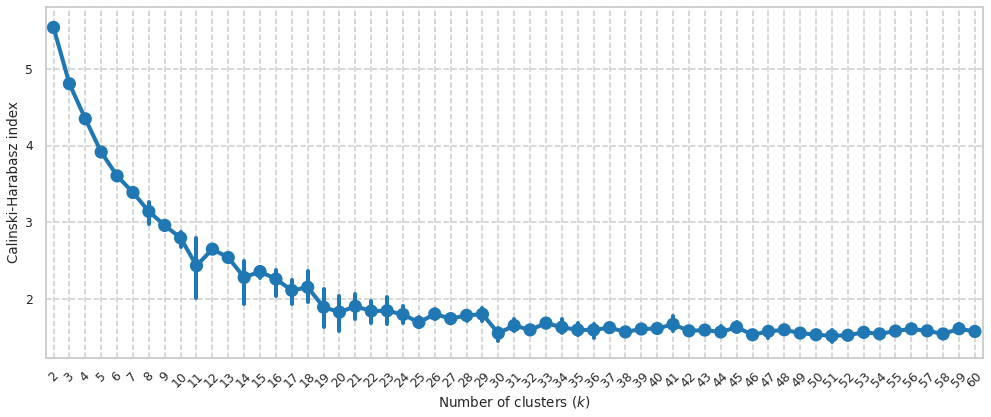

In [40]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="ch_score")
    ax.set_ylabel("Calinski-Harabasz index")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

# Stability

## Group ensemble by n_clusters

In [41]:
parts = ensemble.groupby("n_clusters").apply(
    lambda x: np.concatenate(x["partition"].apply(lambda x: x.reshape(1, -1)), axis=0)
)

In [42]:
parts.head()

n_clusters
2    [[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0,...
3    [[1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0,...
4    [[3.0, 0.0, 2.0, 0.0, 0.0, 0.0, 3.0, 2.0, 2.0,...
5    [[4.0, 0.0, 1.0, 4.0, 2.0, 1.0, 3.0, 0.0, 2.0,...
6    [[5.0, 2.0, 2.0, 0.0, 0.0, 5.0, 0.0, 5.0, 5.0,...
dtype: object

In [43]:
assert np.all(
    [
        parts.loc[k].shape == (CLUSTERING_OPTIONS["N_REPS_PER_K"], data.shape[0])
        for k in parts.index
    ]
)

## Compute stability

In [44]:
from sklearn.metrics import adjusted_rand_score as ari
from scipy.spatial.distance import pdist

In [45]:
parts_ari = pd.Series(
    {k: pdist(parts.loc[k], metric=ari) for k in parts.index}, name="k"
)

In [46]:
parts_ari_stability = parts_ari.apply(lambda x: x.mean())
display(parts_ari_stability.sort_values(ascending=False).head(15))

45    0.020830
52    0.020179
47    0.015444
58    0.013875
25    0.012781
48    0.012345
54    0.010744
15    0.010417
44    0.009578
55    0.009397
33    0.008738
36    0.008384
49    0.008133
46    0.008035
23    0.007828
Name: k, dtype: float64

In [47]:
parts_ari_df = pd.DataFrame.from_records(parts_ari.tolist()).set_index(
    parts_ari.index.copy()
)

In [48]:
parts_ari_df.shape

(59, 10)

In [49]:
assert (
    int(
        (CLUSTERING_OPTIONS["N_REPS_PER_K"] * (CLUSTERING_OPTIONS["N_REPS_PER_K"] - 1))
        / 2
    )
    == parts_ari_df.shape[1]
)

In [50]:
parts_ari_df.head()

,0,1,2,3,4,5,6,7,8,9
2,0.032741,0.024926,0.000265,-0.000304,-0.000503,0.003248,-0.000397,0.001737,0.004729,0.008789
3,0.005968,-0.000516,0.008970,0.003864,0.008951,0.008181,0.009740,0.001057,-0.000117,0.009255
4,0.006505,0.007198,0.002503,0.004006,0.001796,0.006499,0.003297,0.006263,0.002237,0.008726
5,0.005383,0.022783,0.003036,0.004971,0.005542,0.006965,0.003163,0.006563,0.005212,0.001480
6,0.005440,0.003493,0.003661,0.008507,0.003592,0.002984,0.003591,0.004391,0.001128,0.002698


## Save

In [51]:
output_filename = Path(
    RESULTS_DIR,
    generate_result_set_name(
        CLUSTERING_OPTIONS,
        prefix=f"{clustering_method_name}-stability-",
        suffix=".pkl",
    ),
).resolve()
display(output_filename)

PosixPath('/opt/data/results/clustering/null_sims/runs/z_score_std-projection-smultixcan-efo_partial-mashr-zscores/KMeans-stability-KMEANS_N_INIT_10-K_MAX_60-K_MIN_2-N_REPS_PER_K_5.pkl')

In [52]:
parts_ari_df.to_pickle(output_filename)

## Stability plot

In [53]:
parts_ari_df_plot = (
    parts_ari_df.stack()
    .reset_index()
    .rename(columns={"level_0": "k", "level_1": "idx", 0: "ari"})
)

In [54]:
parts_ari_df_plot.dtypes

k        int64
idx      int64
ari    float64
dtype: object

In [55]:
parts_ari_df_plot.head()

,k,idx,ari
0,2,0,0.032741
1,2,1,0.024926
2,2,2,0.000265
3,2,3,-0.000304
4,2,4,-0.000503


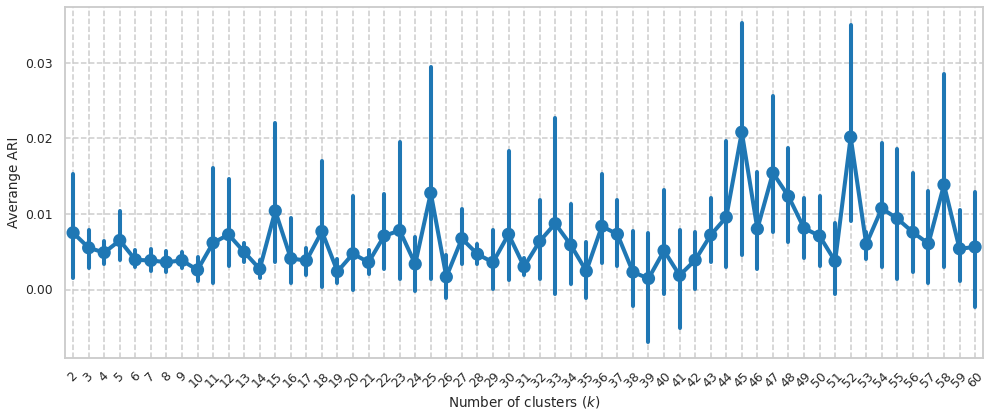

In [56]:
# with sns.axes_style('whitegrid', {'grid.linestyle': '--'}):
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=parts_ari_df_plot, x="k", y="ari")
    ax.set_ylabel("Averange ARI")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    #     ax.set_ylim(0.0, 1.0)
    #     ax.set_xlim(CLUSTERING_OPTIONS['K_MIN'], CLUSTERING_OPTIONS['K_MAX'])
    plt.grid(True)
    plt.tight_layout()